<a href="https://colab.research.google.com/github/jrleonett/CLIP-Interrogador/blob/main/visioncomputacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento de imágenes con YOLO y Visión por Computadora

Este proyecto utiliza el modelo YOLO (You Only Look Once) para procesar imágenes y detectar objetos en ellas. El código está dividido en tres fases principales: creación de una carpeta para almacenar resultados, procesamiento de la imagen y descarga de los resultados en un archivo ZIP. Realizado por **José R. Leonett** para la comunidad de peritos forenses digitales de Guatemala www.forensedigital.gt

In [1]:
#@title Fase 1: Carga de variables y creación de la carpeta "EVIDENCIA"

import os

# Crear la carpeta "EVIDENCIAS" si no existe
if not os.path.exists('EVIDENCIAS'):
    os.makedirs('EVIDENCIAS')

print("Carpeta 'EVIDENCIAS' creada.")

Carpeta 'EVIDENCIAS' creada.


Imagen original:


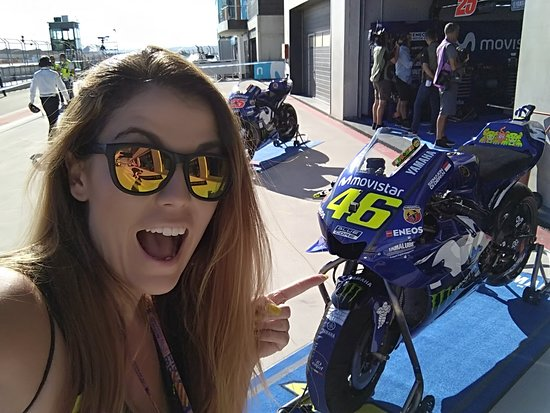

Imagen con objetos detectados:


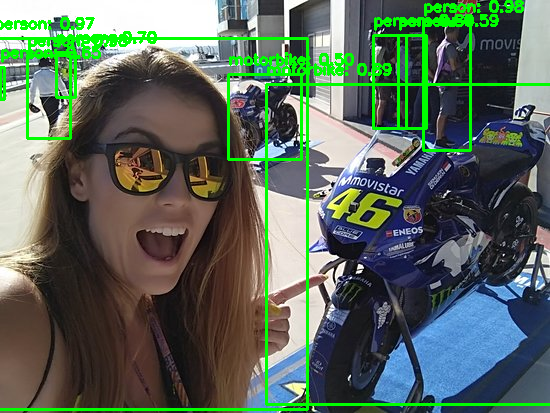

Imagen con detecciones guardada en EVIDENCIAS/selfie-moto_detectAI.jpg


In [3]:
#@title Fase 2: Procesamiento de la imagen y detección de objetos

import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

# Descargar los archivos de YOLO si no existen
if not os.path.exists("yolov3.cfg") or not os.path.exists("yolov3.weights") or not os.path.exists("coco.names"):
    print("Descargando archivos de YOLO...")
    !wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
    !wget https://pjreddie.com/media/files/yolov3.weights
    !wget https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true -O coco.names
    print("Archivos de YOLO descargados correctamente.")

# Cargar YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
with open("coco.names", "r") as f:
    classes = f.read().strip().split("\n")

# Leer la imagen de la carpeta "EVIDENCIAS"
evidencia_files = os.listdir('EVIDENCIAS')
image_extensions = ['.jpg', '.jpeg', '.png']
image_name = None

# Buscar la primera imagen válida en la carpeta
for file in evidencia_files:
    if any(file.lower().endswith(ext) for ext in image_extensions):
        image_name = file
        break

if not image_name:
    raise FileNotFoundError("No se encontró ninguna imagen válida (JPG o PNG) en la carpeta 'EVIDENCIAS'.")

image_path = os.path.join('EVIDENCIAS', image_name)
image = cv2.imread(image_path)

if image is None:
    raise ValueError("No se pudo cargar la imagen. Asegúrate de que el archivo sea un JPG o PNG válido.")

# Obtener dimensiones de la imagen
height, width, _ = image.shape

# Preprocesar la imagen para YOLO
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Obtener las capas de salida
layer_names = net.getLayerNames()
output_layers_indices = net.getUnconnectedOutLayers()

# Verificar si output_layers_indices es una lista de listas o una lista de enteros
if isinstance(output_layers_indices[0], list):
    output_layers = [layer_names[i[0] - 1] for i in output_layers_indices]
else:
    output_layers = [layer_names[i - 1] for i in output_layers_indices]

detections = net.forward(output_layers)

# Procesar las detecciones
conf_threshold = 0.5
nms_threshold = 0.4
boxes = []
confidences = []
class_ids = []

for output in detections:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > conf_threshold:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Aplicar Non-Maximum Suppression (NMS)
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

# Dibujar las cajas y etiquetas en la imagen
image_detected = image.copy()
for i in indices:
    i = i[0] if isinstance(i, (list, np.ndarray)) else i
    box = boxes[i]
    x, y, w, h = box
    label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
    cv2.rectangle(image_detected, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image_detected, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Mostrar la imagen original y la imagen con detecciones
print("Imagen original:")
cv2_imshow(image)

print("Imagen con objetos detectados:")
cv2_imshow(image_detected)

# Guardar la imagen con detecciones en la carpeta "EVIDENCIAS"
output_image_name = image_name.replace(".jpg", "_detectAI.jpg").replace(".jpeg", "_detectAI.jpg").replace(".png", "_detectAI.png")
output_image_path = os.path.join('EVIDENCIAS', output_image_name)
cv2.imwrite(output_image_path, image_detected)
print(f"Imagen con detecciones guardada en {output_image_path}")

In [ ]:
#@title Fase 3: Descargar los resultados en un archivo ZIP

import zipfile
from google.colab import files

# Crear un archivo ZIP con las imágenes de la carpeta "EVIDENCIAS"
zip_path = 'EVIDENCIAS.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, dirs, files_in_folder in os.walk('EVIDENCIAS'):
        for file in files_in_folder:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=file)

# Descargar el archivo ZIP
files.download(zip_path)
print(f"Archivo {zip_path} descargado.")

# Zona de resultados